In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [2]:
import gc
import torch
import torchvision

from torch import nn

from config import (
    IMAGE_DIMENSION_CIFAR,
    EPOCHS_PRO_MAX,
    get_device,
    LEARNING_RATE,
    WEIGHT_DECAY,
    BATCH_SIZE_PRO,
)
from utils import download_cifar10, get_data_loaders, print_model_summary

print(torch.__version__)
print(torchvision.__version__)


DEVICE: torch.device = get_device()


2.10.0+cu128
0.25.0+cu128
Using DEVICE: cuda


In [3]:
train_dataset, test_dataset = download_cifar10(img_dimensions=IMAGE_DIMENSION_CIFAR)


print("\nDataset Statistics:")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


CIFAR-10 ready  train=50000  test=10000  channels=3

Dataset Statistics:
Training samples: 50000
Testing samples: 10000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [4]:
train_dataloader, test_dataloader, class_names, data_channel = get_data_loaders(
    test_dataset=test_dataset, train_dataset=train_dataset, batch_size=BATCH_SIZE_PRO
)

print("DataLoader Information:")
print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


DataLoader Information:
Train batches: 782
Test batches: 157


In [5]:
images, labels = next(iter(train_dataloader))
print(f"Images: {images.shape}")
print(f"Labels: {labels.shape}")

Images: torch.Size([64, 3, 32, 32])
Labels: torch.Size([64])


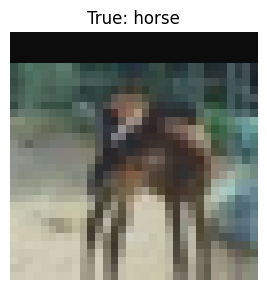

In [6]:
from utils import (
    show_img,
    show_wavelet_subbands,
    show_gabor_responses,
    show_log_responses,
    show_lbp_responses,
    show_dog_responses,
    apply_sobel_for_vis,
    show_img_grayscale,
)

show_img(images[5], labels[5], classes_str=class_names)


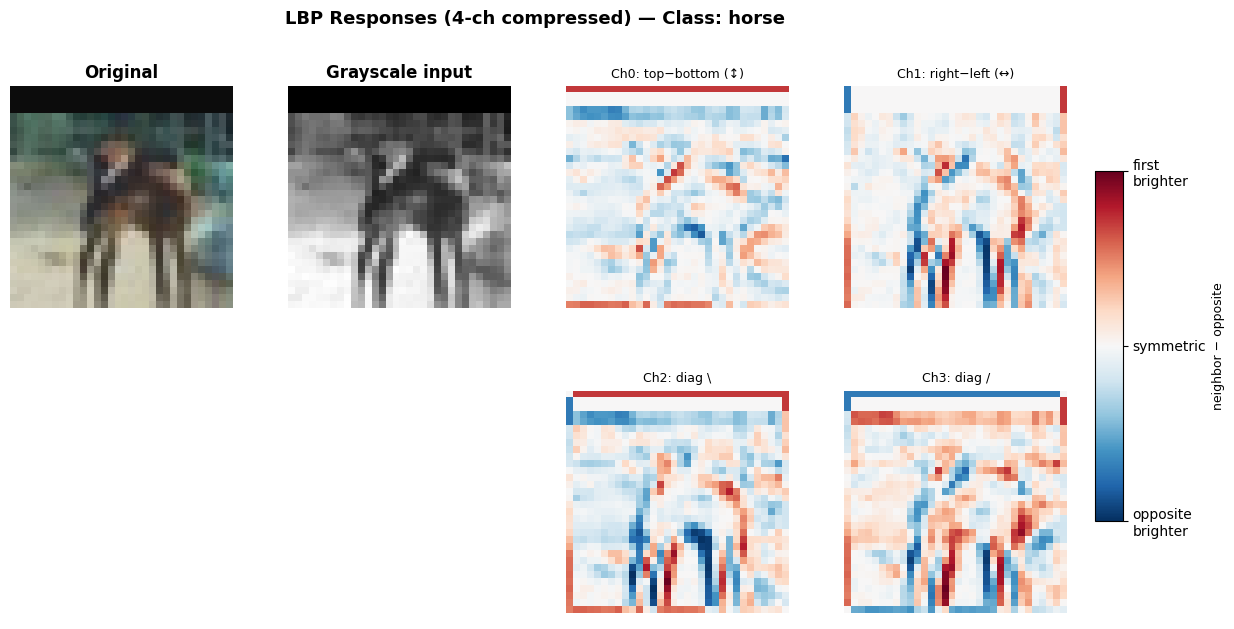

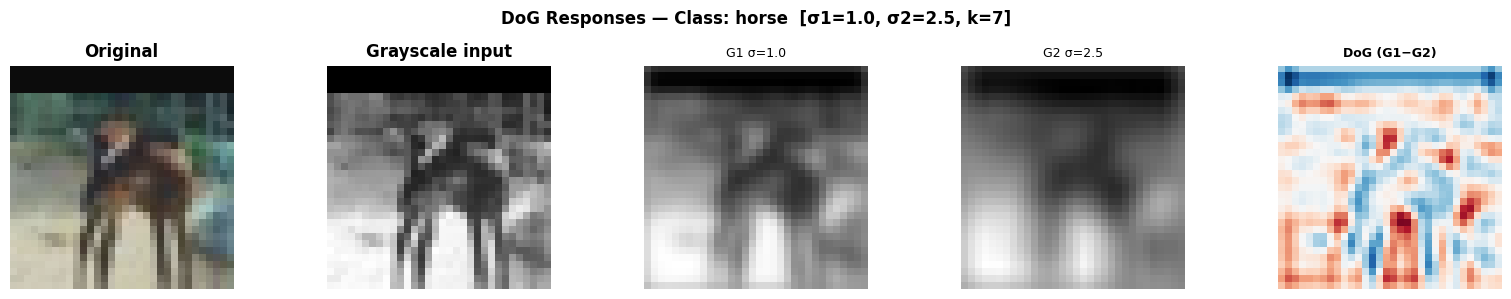

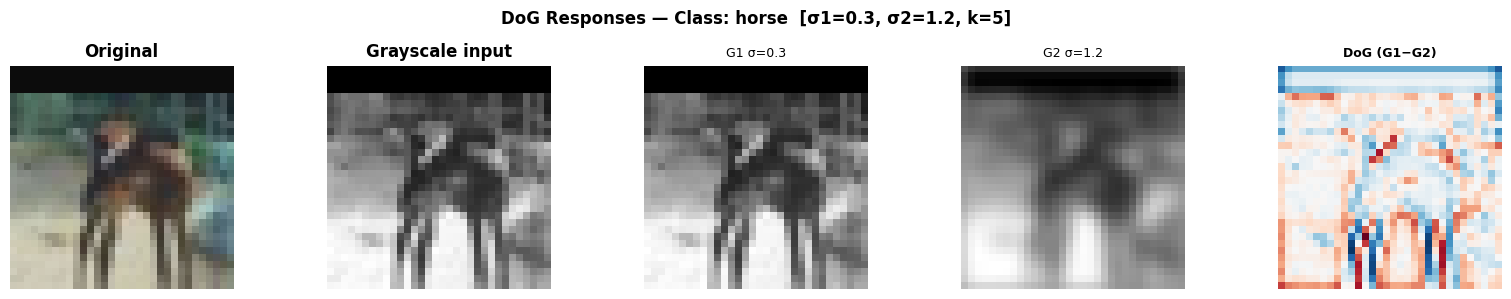

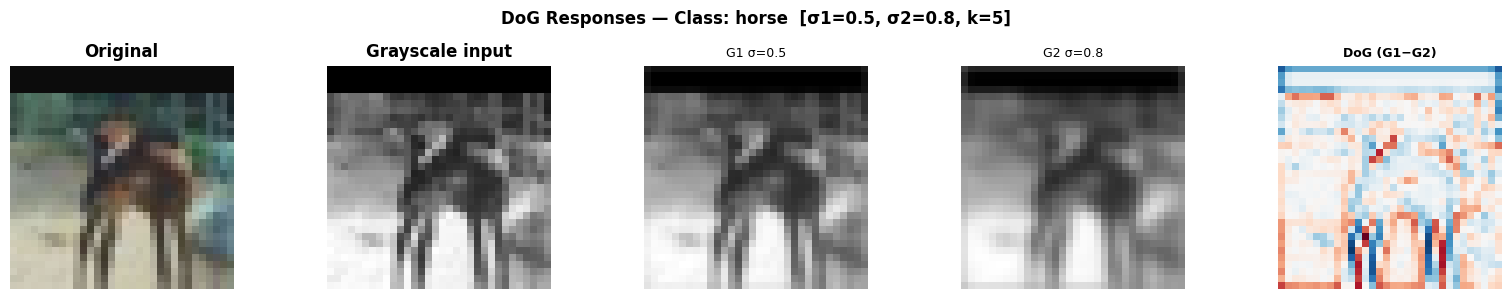

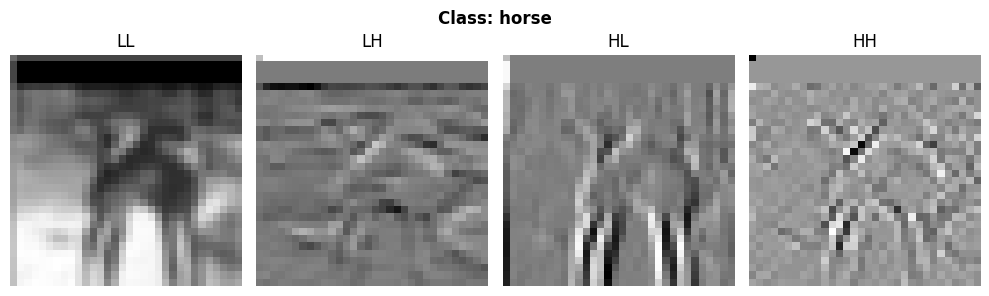

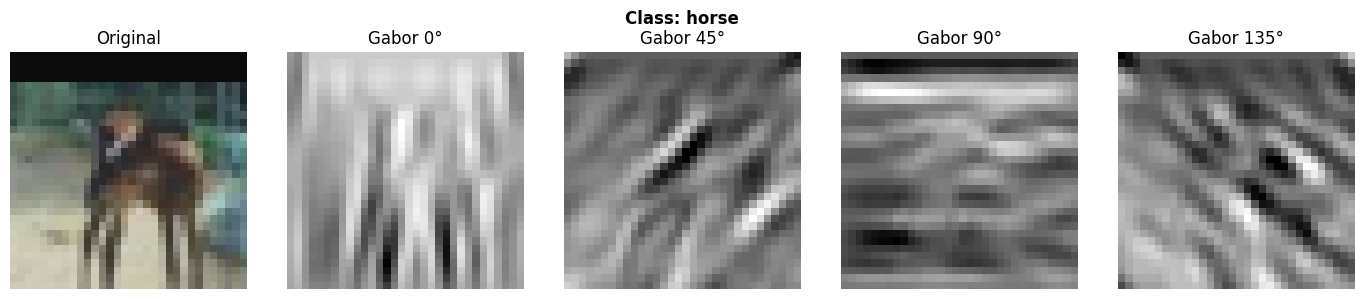

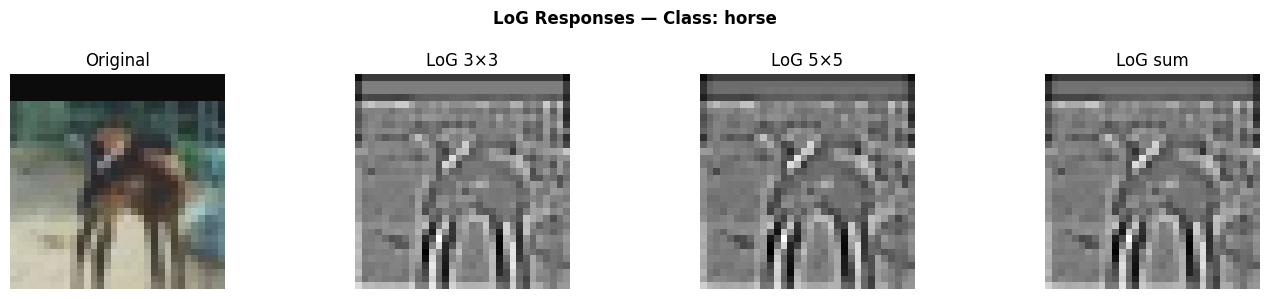

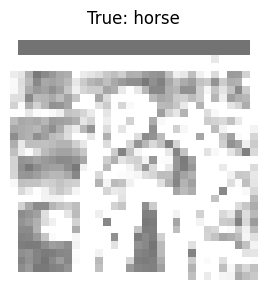

In [7]:
show_lbp_responses(x=images[5], y=labels[5], classes_str=class_names)
show_dog_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
)

show_dog_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
    sigma1=0.3,
    sigma2=1.2,
    kernel_size=5,
)
show_dog_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
    sigma1=0.5,
    sigma2=0.8,
    kernel_size=5,
)

show_wavelet_subbands(x=images[5], y=labels[5], classes_str=class_names)
show_gabor_responses(
    x=images[5],
    y=labels[5],
    classes_str=class_names,
    orientations=(0, 45, 90, 135),
    kernel_size=7,
)
show_log_responses(x=images[5], y=labels[5], classes_str=class_names)
x = apply_sobel_for_vis(images[5])
show_img_grayscale(X=x, y=labels[5], classes_str=class_names)


In [8]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

model_cifar_train = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1.5, BranchType.FILTER: 1},
    filter_channels=14,
    filters=[FilterType.LBP],
    tail_depth=1,
)

In [9]:
print_model_summary(model=model_cifar_train, img_dim=IMAGE_DIMENSION_CIFAR)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 32, 32]            [1, 1, 32, 32]            (3)                       3,072
├─Sequential: 1-2                                       [1, 3, 32, 32]            [1, 40, 8, 8]             --                        --
│    └─Conv2d: 2-1                                      [1, 3, 32, 32]            [1, 16, 32, 32]           48                        49,152
│    └─BatchNorm2d: 2-2                                 [1, 16, 32, 32]           [1, 16, 32, 32]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 32, 32]           [1, 16, 32, 32]           --                        --
│    └─DepthwiseConv: 2-4  

In [10]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_cifar_train,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_CIFAR,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/mcu/cifar10_mcu_medium",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 66,413 params | Dataset: 50,000 samples | base_lr: 3e-03
Warmup: 8 epochs → peak 3e-03 | Cosine: 92 epochs → 1.9e-06
LR preview:
  Epoch   1: 3.00e-04
  Epoch   2: 6.38e-04
  Epoch   3: 9.75e-04
  Epoch   4: 1.31e-03
  Epoch   5: 1.65e-03
  Epoch   9: 3.00e-03
  Epoch  98: 8.86e-06
  Epoch  99: 4.50e-06
  Epoch 100: 1.87e-06
EMA decay: 0.9997  (≈5-epoch window, 3910 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00064
  Train  Acc: 41.18%  Loss: 1.7636
  Test   Acc: 9.19%  Loss: 2.3663
Best saved (Test Acc: 9.19%)
-----------------------------------
Epoch   2/100 | LR: 0.00098
  Train  Acc: 56.33%  Loss: 1.4559
  Test   Acc: 13.68%  Loss: 2.3572
Best saved (Test Acc: 13.68%)
-----------------------------------
Epoch   3/100 | LR: 0.00131
  Train  Acc: 62.65%  Loss: 1.3277
  Test   Acc: 16.04%  Loss: 2.3040
Best saved (Test Acc: 16.04%)
-----------------------------------
Epoch   4/100 | LR: 0.00165
  

In [11]:
tta_acc = evaluate_tta(
    model=model_cifar_train, test_loader=test_dataloader, device=DEVICE
)
tta_acc

0.8378999829292297

Generating predictions for Confusion Matrix...


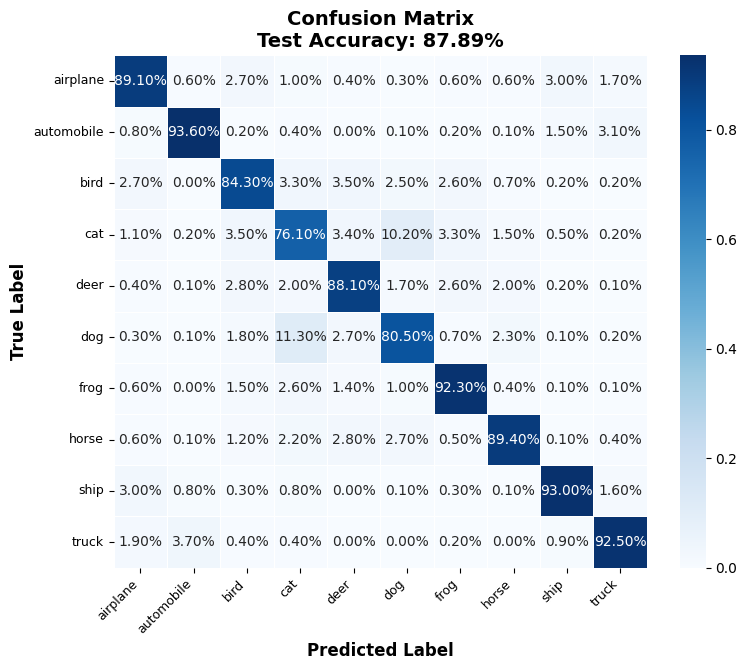


Most Confused Pairs (Errors > 10.00%):
  - True 'cat' predicted as 'dog': 10.2%
  - True 'dog' predicted as 'cat': 11.3%


In [12]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_cifar_train,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)


In [13]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               87.89% 99.50%     66,416       3.9      0.23    2.69   372.3  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 87.89% Top-1 | 66,416 params | 2.69 ± 0.17 ms | 372.3 FPS



Saved → ../figure/solo/train_cifar_mcu_medium.pdf / .png


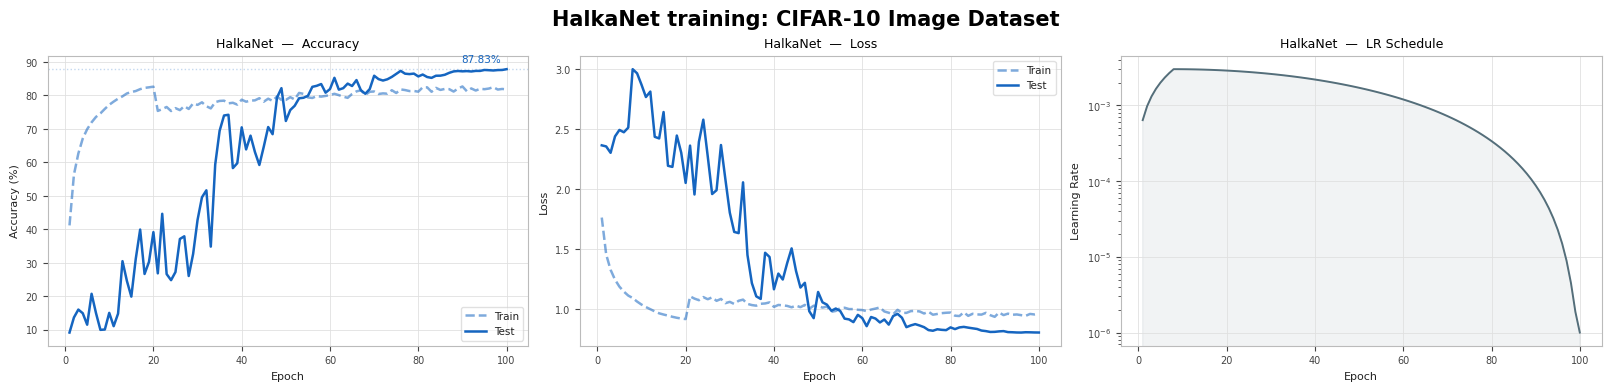

In [14]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/solo/train_cifar_mcu_medium.pdf",
    dataset_name="CIFAR-10 Image Dataset",
    title="HalkaNet training:",
)

In [15]:
from utils import export_to_onnx
from models import HalkaNet
from config import BranchType, FilterType
import torch

model = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1.5, BranchType.FILTER: 1},
    filter_channels=14,
    filters=[FilterType.LBP],
    tail_depth=1,
)

# ── 2. Load checkpoint (with buffer key patching) ──────────────────────────────
ckpt = torch.load(
    "../checkpoints/mcu/cifar10_mcu_medium/halkanet.pth", map_location="cpu"
)
state = ckpt["model_state_dict"]
current_sd = model.state_dict()
for k in [
    "coarse_filter_modules.3.weight",
    "coarse_filter_modules.4.weight",
    "fine_filter_modules.3.weight",
    "fine_filter_modules.4.weight",
]:
    if k not in state and k in current_sd:
        state[k] = current_sd[k]

model.load_state_dict(state, strict=True)
model.eval()
print(f"✓ Loaded | epoch={ckpt['epoch']} | test_acc={ckpt['test_acc']:.4f}")

# ── 3. Export ──────────────────────────────────────────────────────────────────
result = export_to_onnx(
    model,
    output_path="../exports/halkanet_cifar10_medium.onnx",
    input_shape=(1, 3, 32, 32),
    quantize=True,
    test_loader=test_dataloader,
    max_eval_samples=500,
)
print(result)


✓ Loaded | epoch=100 | test_acc=0.8783
✓ ONNX export → ../exports/halkanet_cifar10_medium.onnx  (opset 11)


✓ INT8 export  → ../exports/halkanet_cifar10_medium_int8.onnx
── Export Result ─────────────────────────────
  float32 : ../exports/halkanet_cifar10_medium.onnx  (248.5 KB)
  int8    : ../exports/halkanet_cifar10_medium_int8.onnx (135.8 KB, 1.8x smaller)

  Accuracy over 512 samples:
    float32 : 88.09%
    int8    : 83.01%  (Δ +5.08 pp)
──────────────────────────────────────────────


In [16]:
from utils import cleanup

cleanup(results, model_cifar_train)

CUDA  Allocated 18.7 MB  Reserved 46.1 MB


In [17]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

model_cifar_train = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1.5, BranchType.FILTER: 1},
    filter_channels=10,
    filters=[FilterType.LBP],
    tail_depth=1,
)

In [18]:
print_model_summary(model=model_cifar_train, img_dim=IMAGE_DIMENSION_CIFAR)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 32, 32]            [1, 1, 32, 32]            (3)                       3,072
├─Sequential: 1-2                                       [1, 3, 32, 32]            [1, 40, 8, 8]             --                        --
│    └─Conv2d: 2-1                                      [1, 3, 32, 32]            [1, 16, 32, 32]           48                        49,152
│    └─BatchNorm2d: 2-2                                 [1, 16, 32, 32]           [1, 16, 32, 32]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 32, 32]           [1, 16, 32, 32]           --                        --
│    └─DepthwiseConv: 2-4  

In [19]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_cifar_train,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_CIFAR,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/mcu/cifar10_mcu_small",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 47,527 params | Dataset: 50,000 samples | base_lr: 3e-03
Warmup: 8 epochs → peak 3e-03 | Cosine: 92 epochs → 1.9e-06
LR preview:
  Epoch   1: 3.00e-04
  Epoch   2: 6.38e-04
  Epoch   3: 9.75e-04
  Epoch   4: 1.31e-03
  Epoch   5: 1.65e-03
  Epoch   9: 3.00e-03
  Epoch  98: 8.86e-06
  Epoch  99: 4.50e-06
  Epoch 100: 1.87e-06
EMA decay: 0.9997  (≈5-epoch window, 3910 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00064
  Train  Acc: 38.26%  Loss: 1.8273
  Test   Acc: 17.03%  Loss: 2.3094
Best saved (Test Acc: 17.03%)
-----------------------------------
Epoch   2/100 | LR: 0.00098
  Train  Acc: 53.33%  Loss: 1.5196
  Test   Acc: 17.56%  Loss: 2.2750
Best saved (Test Acc: 17.56%)
-----------------------------------
Epoch   3/100 | LR: 0.00131
  Train  Acc: 59.91%  Loss: 1.3824
  Test   Acc: 11.19%  Loss: 2.6049
-----------------------------------
Epoch   4/100 | LR: 0.00165
  Train  Acc: 64.44%  Loss: 1.

In [20]:
tta_acc = evaluate_tta(
    model=model_cifar_train, test_loader=test_dataloader, device=DEVICE
)
tta_acc

0.8310999870300293

Generating predictions for Confusion Matrix...


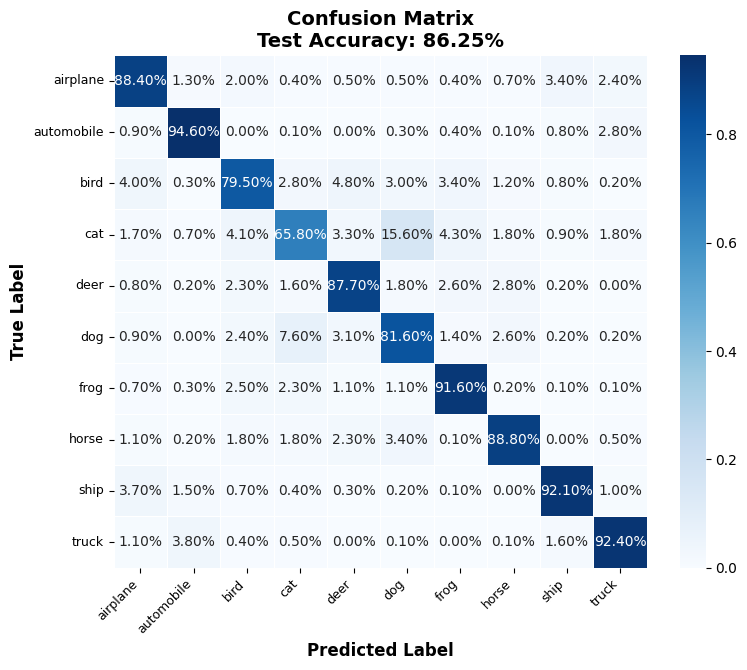


Most Confused Pairs (Errors > 10.00%):
  - True 'cat' predicted as 'dog': 15.6%


In [21]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_cifar_train,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)

In [22]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               86.25% 99.27%     47,530       2.9      0.16    2.33   429.4  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 86.25% Top-1 | 47,530 params | 2.33 ± 0.12 ms | 429.4 FPS



Saved → ../figure/solo/train_cifar_mcu_small.pdf / .png


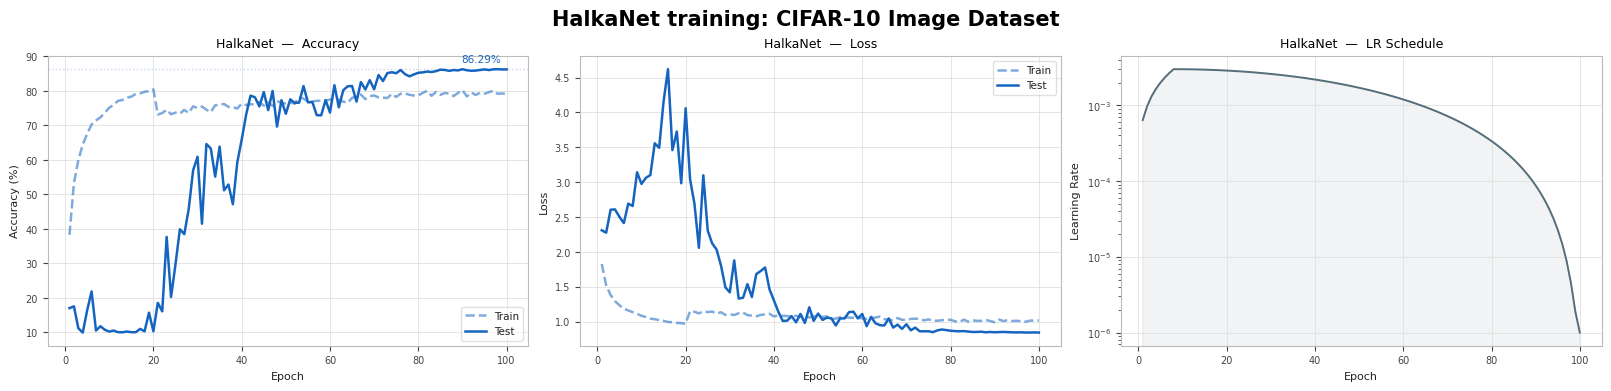

In [23]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/solo/train_cifar_mcu_small.pdf",
    dataset_name="CIFAR-10 Image Dataset",
    title="HalkaNet training:",
)

In [24]:
from utils import export_to_onnx
from models import HalkaNet
from config import BranchType, FilterType
import torch

model = HalkaNet(
    num_classes=len(class_names),
    skip_expansion={BranchType.RGB: 1.5, BranchType.FILTER: 1},
    filter_channels=10,
    filters=[FilterType.LBP],
    tail_depth=1,
)

# ── 2. Load checkpoint (with buffer key patching) ──────────────────────────────
ckpt = torch.load(
    "../checkpoints/mcu/cifar10_mcu_small/halkanet.pth", map_location="cpu"
)
state = ckpt["model_state_dict"]
current_sd = model.state_dict()
for k in [
    "coarse_filter_modules.3.weight",
    "coarse_filter_modules.4.weight",
    "fine_filter_modules.3.weight",
    "fine_filter_modules.4.weight",
]:
    if k not in state and k in current_sd:
        state[k] = current_sd[k]

model.load_state_dict(state, strict=True)
model.eval()
print(f"✓ Loaded | epoch={ckpt['epoch']} | test_acc={ckpt['test_acc']:.4f}")

# ── 3. Export ──────────────────────────────────────────────────────────────────
result = export_to_onnx(
    model,
    output_path="../exports/halkanet_cifar10_small.onnx",
    input_shape=(1, 3, 32, 32),
    quantize=True,
    test_loader=test_dataloader,
    max_eval_samples=500,
)
print(result)

✓ Loaded | epoch=98 | test_acc=0.8629
✓ ONNX export → ../exports/halkanet_cifar10_small.onnx  (opset 11)
✓ INT8 export  → ../exports/halkanet_cifar10_small_int8.onnx
── Export Result ─────────────────────────────
  float32 : ../exports/halkanet_cifar10_small.onnx   (186.2 KB)
  int8    : ../exports/halkanet_cifar10_small_int8.onnx (119.6 KB, 1.6x smaller)

  Accuracy over 512 samples:
    float32 : 86.52%
    int8    : 86.33%  (Δ +0.20 pp)
──────────────────────────────────────────────


In [25]:
from utils import cleanup

cleanup(results, model_cifar_train)

CUDA  Allocated 18.5 MB  Reserved 50.3 MB


In [5]:
from utils import set_seed
from config import BranchType, LABEL_SMOOTHING, FilterType
from models import HalkaNet

set_seed()

model_cifar_train = HalkaNet(
    num_classes=len(class_names),
    rgb_stem_channels=16,
    skip_expansion={BranchType.RGB: 1.5, BranchType.FILTER: 1.5},
    filter_channels=22,
    filters=[FilterType.LBP, FilterType.LOG, FilterType.GABOR, FilterType.WAVE],
    # tail_depth=2,
)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = torch.optim.AdamW(
    model_cifar_train.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)


In [6]:
print_model_summary(model=model_cifar_train, img_dim=IMAGE_DIMENSION_CIFAR)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Mult-Adds
HalkaNet                                                [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d: 1-1                                           [1, 3, 32, 32]            [1, 1, 32, 32]            (3)                       3,072
├─Sequential: 1-2                                       [1, 3, 32, 32]            [1, 40, 8, 8]             --                        --
│    └─Conv2d: 2-1                                      [1, 3, 32, 32]            [1, 16, 32, 32]           48                        49,152
│    └─BatchNorm2d: 2-2                                 [1, 16, 32, 32]           [1, 16, 32, 32]           32                        32
│    └─ReLU: 2-3                                        [1, 16, 32, 32]           [1, 16, 32, 32]           --                        --
│    └─DepthwiseConv: 2-4  

In [28]:
from utils import evaluate_tta, run_experiment
from config import CHECKPOINT_DIR

results = run_experiment(
    halkanet=model_cifar_train,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    device=DEVICE,
    num_classes=len(class_names),
    img_dim=IMAGE_DIMENSION_CIFAR,
    epochs=EPOCHS_PRO_MAX,
    patience=30,
    use_cutmix=True,
    cutmix_alpha=0.4,
    cutmix_prob=0.3,
    cutmix_start_epoch=20,
    compare=False,
    checkpoint_dir=f"{CHECKPOINT_DIR}/mcu/cifar10_mcu_large",
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
)


  Training HalkaNet

Model: 137,733 params | Dataset: 50,000 samples | base_lr: 3e-03
Warmup: 8 epochs → peak 3e-03 | Cosine: 92 epochs → 1.9e-06
LR preview:
  Epoch   1: 3.00e-04
  Epoch   2: 6.38e-04
  Epoch   3: 9.75e-04
  Epoch   4: 1.31e-03
  Epoch   5: 1.65e-03
  Epoch   9: 3.00e-03
  Epoch  98: 8.86e-06
  Epoch  99: 4.50e-06
  Epoch 100: 1.87e-06
EMA decay: 0.9997  (≈5-epoch window, 3910 steps)

Starting 100 epochs (patience=30) | CutMix: ON (p=0.3, α=0.4, ep=20→100)

Epoch   1/100 | LR: 0.00064
  Train  Acc: 47.37%  Loss: 1.6498
  Test   Acc: 10.96%  Loss: 2.3926
Best saved (Test Acc: 10.96%)
-----------------------------------
Epoch   2/100 | LR: 0.00098
  Train  Acc: 61.42%  Loss: 1.3587
  Test   Acc: 15.41%  Loss: 2.5241
Best saved (Test Acc: 15.41%)
-----------------------------------
Epoch   3/100 | LR: 0.00131
  Train  Acc: 67.57%  Loss: 1.2336
  Test   Acc: 19.75%  Loss: 2.6077
Best saved (Test Acc: 19.75%)
-----------------------------------
Epoch   4/100 | LR: 0.00165

In [29]:
tta_acc = evaluate_tta(
    model=model_cifar_train, test_loader=test_dataloader, device=DEVICE
)
tta_acc

0.8668000102043152

Generating predictions for Confusion Matrix...


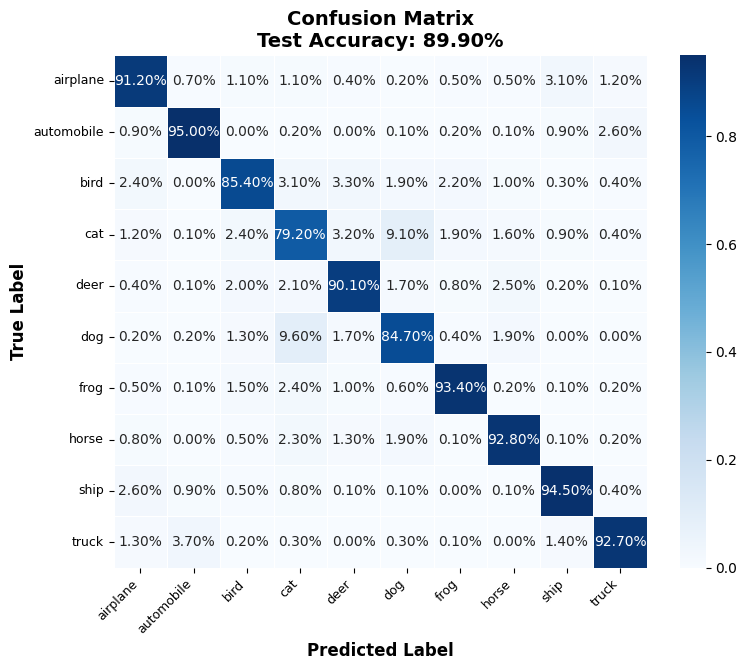


Most Confused Pairs (Errors > 10.00%):


In [30]:
from utils import plot_confusion_matrix

plot_confusion_matrix(
    model=model_cifar_train,
    test_loader=test_dataloader,
    class_names=class_names,
    device=DEVICE,
    threshold=0.1,
)


In [31]:
from utils import print_comparison_table, plot_training_curves
from config import FIGURE_DIR

print_comparison_table(results)


────────────────────────────────────────────────────────────────────────────────────────────────────
  Model                   Top-1  Top-5     Params   MACs(M)  Size(MB)   Lat(ms)     FPS
────────────────────────────────────────────────────────────────────────────────────────────────────
  HalkaNet               89.90% 99.59%    137,736       7.8      0.47    3.69   271.3  ◄
────────────────────────────────────────────────────────────────────────────────────────────────────

  HalkaNet — 89.90% Top-1 | 137,736 params | 3.69 ± 0.74 ms | 271.3 FPS



Saved → ../figure/solo/train_cifar_mcu_large.pdf / .png


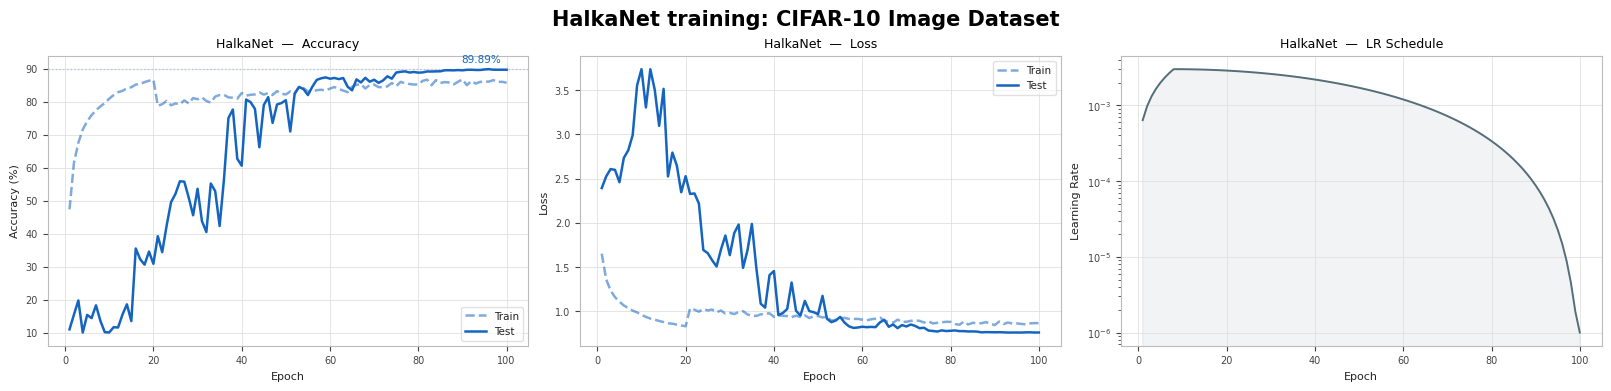

In [32]:
plot_training_curves(
    results,
    save_path=f"{FIGURE_DIR}/solo/train_cifar_mcu_large.pdf",
    dataset_name="CIFAR-10 Image Dataset",
    title="HalkaNet training:",
)